Fundamentos de ciência de dados - Luiz Davi e Thiago Cavalcanti

In [37]:
from nba_api_jogadores_utils import obter_logs_dos_jogos_por_jogador
from constantes_jogadores import DICIONARIO_JOGADORES, TEMPORADA_ATUAL
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Regressão logística: variável alvo

## RF5 – Possível uso  de variáveis independentes:  tempo que o jogador passou em quadra, arremessos tentados e turnovers. Variáveis dependentes, pontos, assistências e rebotes. Divida os dados de teste e treinamento.

Coletando os dados

In [38]:
lista_de_dataframes = []
for nome, id in DICIONARIO_JOGADORES.items():
    dados = obter_logs_dos_jogos_por_jogador(id, TEMPORADA_ATUAL)
    dados = dados[['GAME_DATE', 'MIN', 'FGA', 'TOV', 'PTS', 'AST', 'REB']]
    dados['PLAYER'] = nome
    lista_de_dataframes.append(dados)

In [39]:
dataframe_nba = pd.concat(lista_de_dataframes)
dataframe_nba.columns = ['Data', 'Minutos', 'Arremessos', 'Turnovers', 'Pontos', 'Assistências', 'Rebotes', 'Jogador']

dataframe_nba.head()

,Data,Minutos,Arremessos,Turnovers,Pontos,Assistências,Rebotes,Jogador
0,"FEB 03, 2025",36,13,1,27,10,14,Nikola Jokić
1,"FEB 01, 2025",37,17,4,28,17,13,Nikola Jokić
2,"JAN 31, 2025",37,16,6,28,13,9,Nikola Jokić
3,"JAN 29, 2025",33,15,2,17,6,6,Nikola Jokić
4,"JAN 27, 2025",40,21,4,33,14,12,Nikola Jokić


Selecionando variáveis independentes e dependentes

In [40]:
dataframe_nba['Pontos_acima_media'] = (dataframe_nba['Pontos'] > dataframe_nba['Pontos'].mean()).astype(int)
dataframe_nba['Assistencias_acima_media'] = (dataframe_nba['Assistências'] > dataframe_nba['Assistências'].mean()).astype(int)
dataframe_nba['Rebotes_acima_media'] = (dataframe_nba['Rebotes'] > dataframe_nba['Rebotes'].mean()).astype(int)

Treinando o modelo e fazendo previsões

In [41]:
def treinar_modelo_regressao_logistica(y_label):
    X = dataframe_nba[['Minutos', 'Arremessos', 'Turnovers']]
    y = dataframe_nba[y_label]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

    modelo = LogisticRegression()
    modelo.fit(X_treino, y_treino)

    # Fazer previsões
    y_pred = modelo.predict(X_teste)
    y_prob = modelo.predict_proba(X_teste)[:, 1]  # Probabilidades da classe 1

    return X_teste, y_teste, y_pred, y_prob, modelo

In [42]:
X_teste_pontos, y_teste_pontos, y_pred_pontos, y_prob_pontos, modelo_pontos = treinar_modelo_regressao_logistica('Pontos_acima_media')
X_teste_assistencias, y_teste_assistencias, y_pred_assistencias, y_prob_assistencias, modelo_assistencias = treinar_modelo_regressao_logistica('Assistencias_acima_media')
X_teste_rebotes, y_teste_rebotes, y_pred_rebotes, y_prob_rebotes, modelo_rebotes = treinar_modelo_regressao_logistica('Rebotes_acima_media')

### As probabilidades de o jogador marcar acima e abaixo da média, mediana, moda, máximo e mínimo para pontos, rebotes e assistências.

#### Pontos

In [51]:
resultados_pontos = X_teste_pontos.copy()
resultados_pontos['Probabilidade_acima_media_pontos'] = y_prob_pontos
resultados_pontos['Previsao'] = y_pred_pontos
resultados_pontos['Real'] = y_teste_pontos.values

resultados_pontos.head()

,Minutos,Arremessos,Turnovers,Probabilidade_acima_media_pontos,Previsao,Real
45,39,18,3,0.659226,1,1
11,37,26,5,0.991383,1,1
12,38,21,1,0.839953,1,1
26,39,39,5,0.999980,1,1
20,34,14,1,0.162446,0,1


#### Assistências

In [44]:
resultados_assistencias = X_teste_assistencias.copy()
resultados_assistencias['Probabilidade_acima_media_assistencias'] = y_prob_assistencias
resultados_assistencias['Previsao'] = y_pred_assistencias
resultados_assistencias['Real'] = y_teste_assistencias.values

resultados_assistencias.head()

,Minutos,Arremessos,Turnovers,Probabilidade_acima_media_assistencias,Previsao,Real
45,39,18,3,0.558331,1,0
11,37,26,5,0.811879,1,0
12,38,21,1,0.428491,0,1
26,39,39,5,0.926881,1,1
20,34,14,1,0.269599,0,0


#### Rebotes

In [45]:
resultados_rebotes = X_teste_rebotes.copy()
resultados_rebotes['Probabilidade_acima_media_rebotes'] = y_prob_rebotes
resultados_rebotes['Previsao'] = y_pred_rebotes
resultados_rebotes['Real'] = y_teste_rebotes.values

resultados_rebotes.head()

,Minutos,Arremessos,Turnovers,Probabilidade_acima_media_rebotes,Previsao,Real
45,39,18,3,0.506046,1,0
11,37,26,5,0.726518,1,0
12,38,21,1,0.441285,0,1
26,39,39,5,0.882933,1,1
20,34,14,1,0.285707,0,0


## RF6 –  Apresente gráficos que facilitem a interpretação das previsões como matriz de confusão, gráficos de probabilidade predita, curva roc, gráficos de coeficientes, etc. 

### Matriz de confusão

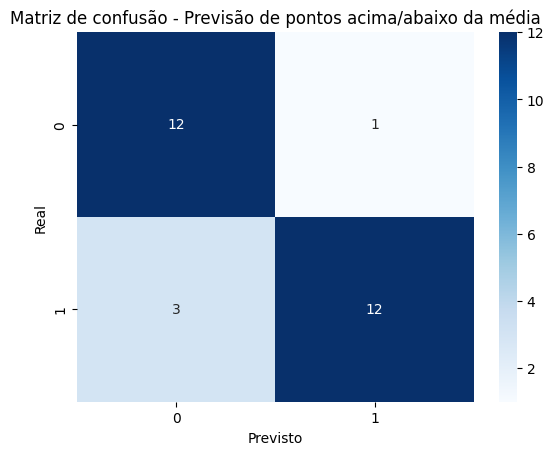

In [46]:
matriz_de_confusao_pontos = confusion_matrix(y_teste_pontos, y_pred_pontos)

sns.heatmap(matriz_de_confusao_pontos, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de confusão - Previsão de pontos acima/abaixo da média')
plt.show()

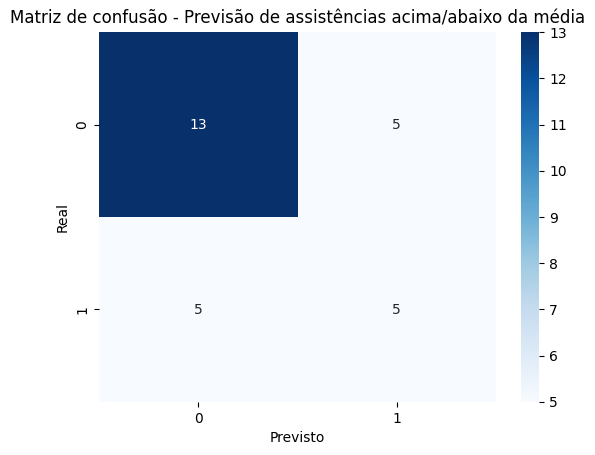

In [47]:
matriz_de_confusao_assistencias = confusion_matrix(y_teste_assistencias, y_pred_assistencias)

sns.heatmap(matriz_de_confusao_assistencias, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de confusão - Previsão de assistências acima/abaixo da média')
plt.show()

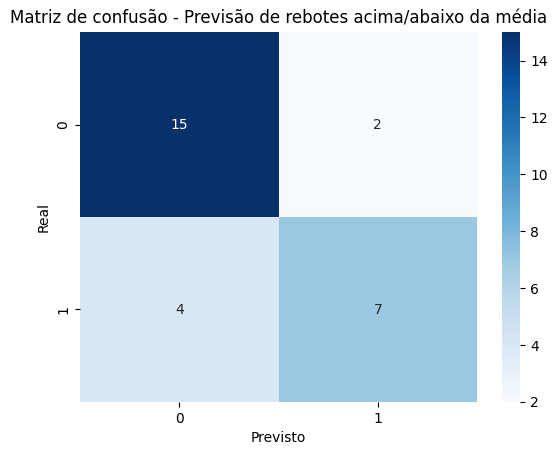

In [48]:
matriz_de_confusao_rebotes = confusion_matrix(y_teste_rebotes, y_pred_rebotes)

sns.heatmap(matriz_de_confusao_rebotes, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de confusão - Previsão de rebotes acima/abaixo da média')
plt.show()

### Gráficos de probabilidade (histogramas de distribuição - real vs previsto)

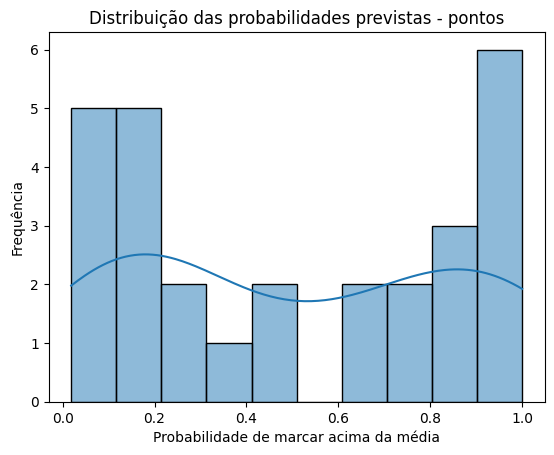

In [60]:
sns.histplot(resultados_pontos['Probabilidade_acima_media_pontos'], bins=10, kde=True)
plt.title('Distribuição das probabilidades previstas - pontos')
plt.xlabel('Probabilidade de marcar acima da média')
plt.ylabel('Frequência')
plt.show()

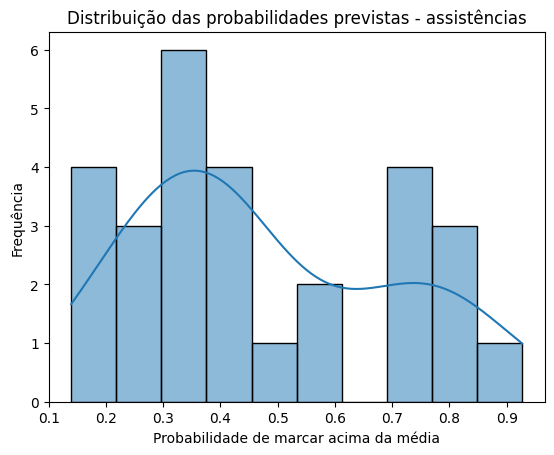

In [58]:
sns.histplot(resultados_assistencias['Probabilidade_acima_media_assistencias'], bins=10, kde=True)
plt.title('Distribuição das probabilidades previstas - assistências')
plt.xlabel('Probabilidade de marcar acima da média')
plt.ylabel('Frequência')
plt.show()

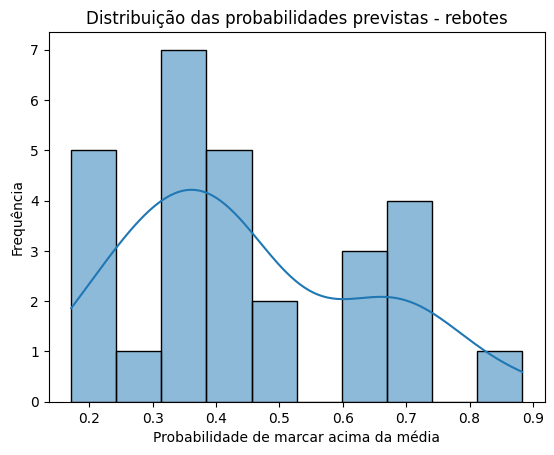

In [59]:
sns.histplot(resultados_rebotes['Probabilidade_acima_media_rebotes'], bins=10, kde=True)
plt.title('Distribuição das probabilidades previstas - rebotes')
plt.xlabel('Probabilidade de marcar acima da média')
plt.ylabel('Frequência')
plt.show()

### Curva ROC

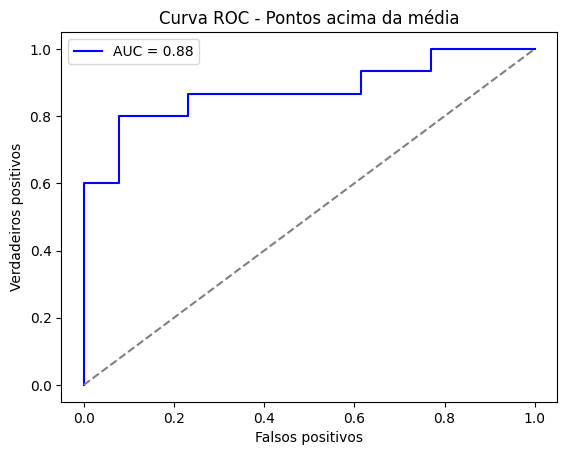

In [61]:
falsos_positivos_pontos, verdadeiros_positivos_pontos, _ = roc_curve(y_teste_pontos, y_prob_pontos)
roc_auc = auc(falsos_positivos_pontos, verdadeiros_positivos_pontos)

plt.plot(falsos_positivos_pontos, verdadeiros_positivos_pontos, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdadeiros positivos')
plt.title('Curva ROC - Pontos acima da média')
plt.legend()
plt.show()

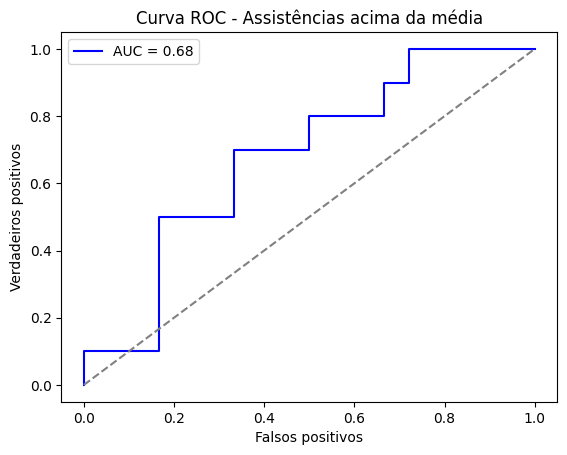

In [62]:
falsos_positivos_assistencias, verdadeiros_positivos_assistencias, _ = roc_curve(y_teste_assistencias, y_prob_assistencias)
roc_auc = auc(falsos_positivos_assistencias, verdadeiros_positivos_assistencias)

plt.plot(falsos_positivos_assistencias, verdadeiros_positivos_assistencias, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdadeiros positivos')
plt.title('Curva ROC - Assistências acima da média')
plt.legend()
plt.show()

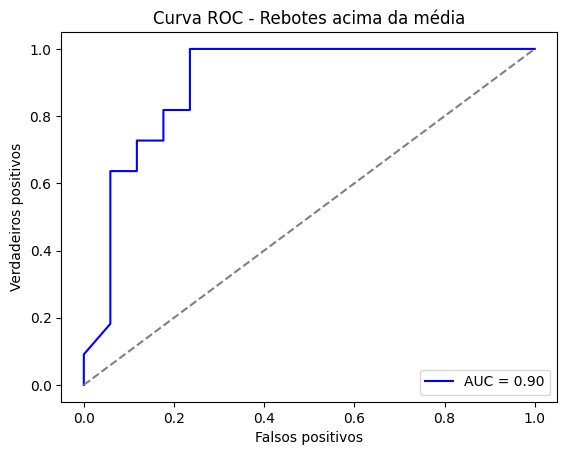

In [63]:
falsos_positivos_rebotess, verdadeiros_positivos_rebotes, _ = roc_curve(y_teste_rebotes, y_prob_rebotes)
roc_auc = auc(falsos_positivos_rebotess, verdadeiros_positivos_rebotes)

plt.plot(falsos_positivos_rebotess, verdadeiros_positivos_rebotes, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdadeiros positivos')
plt.title('Curva ROC - Rebotes acima da média')
plt.legend()
plt.show()

### Gráfico de coeficientes

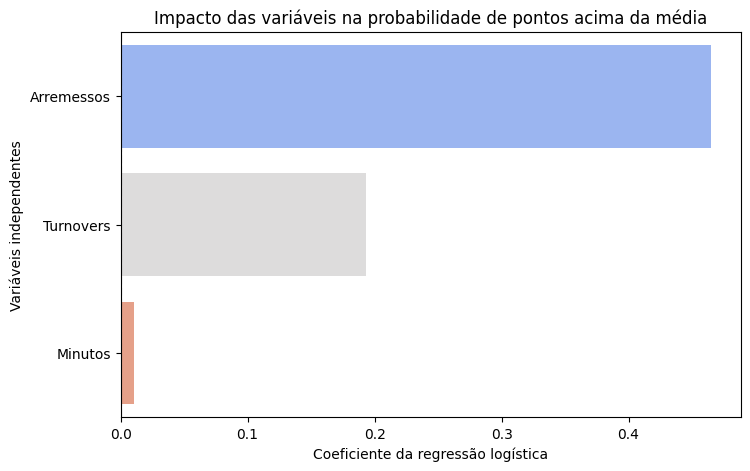

In [67]:
coef_pontos = modelo_pontos.coef_[0]
features_pontos = X_teste_pontos.columns

coef_df_pontos = pd.DataFrame({'Variável': features_pontos, 'Coeficiente': coef_pontos})

coef_df_pontos = coef_df_pontos.sort_values(by='Coeficiente', key=np.abs, ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Coeficiente', y='Variável', hue='Variável', data=coef_df_pontos, palette='coolwarm', legend=False)
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Impacto das variáveis na probabilidade de pontos acima da média')
plt.xlabel('Coeficiente da regressão logística')
plt.ylabel('Variáveis independentes')
plt.show()

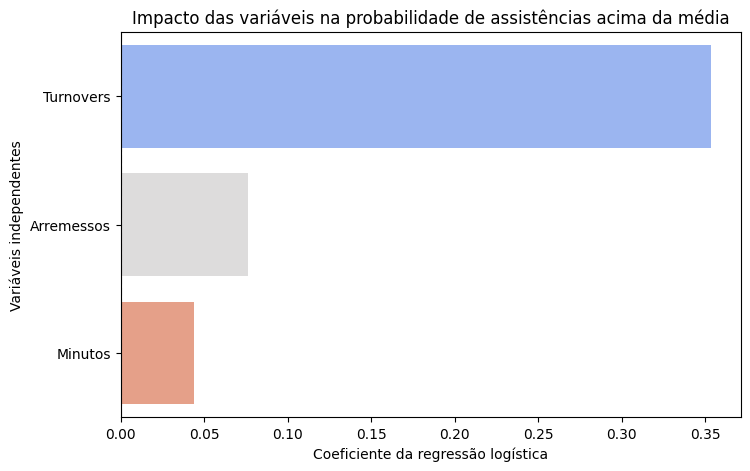

In [69]:
coef_assistencias = modelo_assistencias.coef_[0]
features_assistencias = X_teste_assistencias.columns

coef_df_assistencias = pd.DataFrame({'Variável': features_assistencias, 'Coeficiente': coef_assistencias})

coef_df_assistencias = coef_df_assistencias.sort_values(by='Coeficiente', key=np.abs, ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Coeficiente', y='Variável', hue='Variável', data=coef_df_assistencias, palette='coolwarm', legend=False)
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Impacto das variáveis na probabilidade de assistências acima da média')
plt.xlabel('Coeficiente da regressão logística')
plt.ylabel('Variáveis independentes')
plt.show()

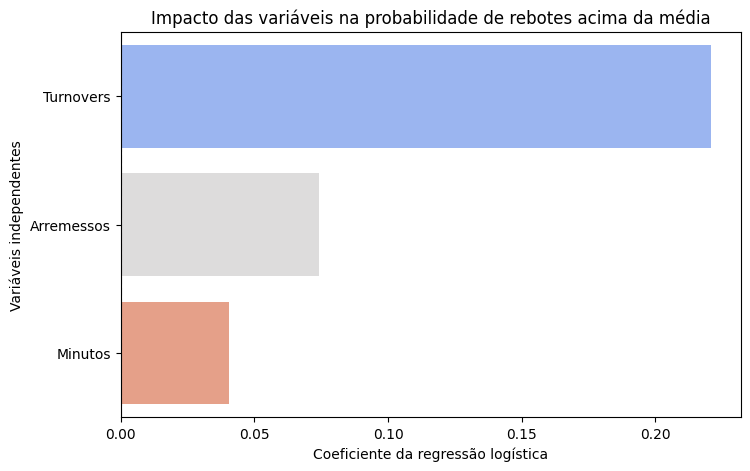

In [70]:
coef_rebotes = modelo_rebotes.coef_[0]
features_rebotes = X_teste_rebotes.columns

coef_df_rebotes = pd.DataFrame({'Variável': features_rebotes, 'Coeficiente': coef_rebotes})

coef_df_rebotes = coef_df_rebotes.sort_values(by='Coeficiente', key=np.abs, ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Coeficiente', y='Variável', hue='Variável', data=coef_df_rebotes, palette='coolwarm', legend=False)
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Impacto das variáveis na probabilidade de rebotes acima da média')
plt.xlabel('Coeficiente da regressão logística')
plt.ylabel('Variáveis independentes')
plt.show()